In [1]:
%pip install catboost xgboost lightgbm

Looking in indexes: https://mirrors.cernet.edu.cn/pypi/web/simple
     ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
      -------------------------------------- 1.8/101.1 MB 39.0 MB/s eta 0:00:03
     -- ------------------------------------ 5.3/101.1 MB 56.4 MB/s eta 0:00:02
     --- ----------------------------------- 8.9/101.1 MB 63.1 MB/s eta 0:00:02
     ---- --------------------------------- 11.2/101.1 MB 65.6 MB/s eta 0:00:02
     ----- -------------------------------- 14.5/101.1 MB 65.6 MB/s eta 0:00:02
     ------ ------------------------------- 17.4/101.1 MB 65.2 MB/s eta 0:00:02
     ------- ------------------------------ 20.1/101.1 MB 59.5 MB/s eta 0:00:02
     -------- ----------------------------- 23.5/101.1 MB 65.6 MB/s eta 0:00:02
     --------- ---------------------------- 26.2/101.1 MB 59.5 MB/s eta 0:00:02
     ----------- -------------------------- 29.3/101.1 MB 65.6 MB/s eta 0:00:02
     ------------ ------------------------- 32.0/101.1 MB 59.

In [137]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import xgboost as xgb

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = []
    # input sequence (t-n, ... t-1) for the first column
    for i in range(n_in, 0, -1):
        cols.append(df.iloc[:, 0].shift(i))
    # forecast sequence (t, t+1, ... t+n) for the first column
    for i in range(0, n_out):
        cols.append(df.iloc[:, 0].shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # 添加剩余的列
    agg = concat([df.iloc[:, 1:], agg], axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values


# load the dataset
series = read_csv('data/Area1_Weather_Load_copy.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=24)
print(data.shape)
# 输出第一个样本
print(data[0])


(26472, 30)
[  20.         13.         16.         59.          0.       3967.259968
 3563.567968 3283.864576 3101.586496 2972.481952 2872.967488 2825.230432
 2721.898528 2674.310752 2940.903712 3182.945824 3328.061152 3179.526496
 2905.11856  2820.243232 2820.690112 2944.5592   3173.022304 3635.882464
 3777.948928 3690.874336 3705.40864  3621.380512 3257.207776 2755.238848]


In [56]:
# 数据标准化standardize,使用标准差
def standardize_data(data):
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    return (data - mean) / std

data = standardize_data(data)

In [57]:
print(data[0])

[-1.00504554 -1.12018519 -1.09284359 -1.10796467 -0.34516876 -1.41053656
 -1.60444595 -1.73885855 -1.82652136 -1.88866849 -1.93662025 -1.95971898
 -2.009514   -2.03253641 -1.90464717 -1.78852451 -1.71893614 -1.79038642
 -1.92230712 -1.9632043  -1.96311482 -1.90373123 -1.79409481 -1.57184527
 -1.50368405 -1.54558595 -1.53867551 -1.57913028 -1.75419084 -1.99548415]


In [142]:
from math import sqrt
from sklearn.metrics import mean_squared_error

m_all = len(data) # 数据集总行数
m_val = int(0.2*m_all) # 验证集数量
m_test = int(0.2*m_all) # 测试集数量
m_train = m_all - m_test - m_val # 训练集数量
# split into input and output columns
X_train,y_train = data[:m_train, :-1], data[:m_train, -1]
X_val,y_val = data[m_train:m_train+m_val, :-1], data[m_train:m_train+m_val, -1]
X_test,y_test = data[m_train+m_val:, :-1], data[m_train+m_val:, -1]
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
# fit model
xgb_params = {
    'device':'cuda',
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'learning_rate': 0.082,
    'max_depth': 10,
    'seed': 2024,
    'nthread': -1,
    'eval_metric': 'mae',
    }
train_matrix = xgb.DMatrix(X_train , label=y_train)
valid_matrix = xgb.DMatrix(X_val , label=y_val)
test_matrix = xgb.DMatrix(X_test , label=y_test)

watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
reg = xgb.train(xgb_params, train_matrix, num_boost_round=350, evals=watchlist)
val_pred  = reg.predict(valid_matrix)
test_pred = reg.predict(test_matrix)
""" reg = xgb.XGBRegressor(xgb_params,n_estimators=1000)
reg.fit(X_train,y_train, eval_set=[(X_val,y_val)],verbose=False) """



(15884, 29) (15884,) (5294, 29) (5294,) (5294, 29) (5294,)
[0]	train-mae:1535.88194	eval-mae:1516.58886
[1]	train-mae:1412.63281	eval-mae:1397.08727
[2]	train-mae:1299.41058	eval-mae:1287.51750
[3]	train-mae:1195.20992	eval-mae:1185.99721
[4]	train-mae:1099.72193	eval-mae:1093.01055
[5]	train-mae:1011.69910	eval-mae:1007.42561
[6]	train-mae:930.79969	eval-mae:928.79024
[7]	train-mae:856.43471	eval-mae:857.23111
[8]	train-mae:788.12839	eval-mae:791.24340
[9]	train-mae:725.29305	eval-mae:731.46121
[10]	train-mae:667.56944	eval-mae:676.11412
[11]	train-mae:614.67785	eval-mae:625.36602
[12]	train-mae:566.03033	eval-mae:578.77096
[13]	train-mae:521.33273	eval-mae:536.14511
[14]	train-mae:480.29665	eval-mae:496.95090
[15]	train-mae:442.47126	eval-mae:460.78473
[16]	train-mae:407.95215	eval-mae:428.53364
[17]	train-mae:376.08241	eval-mae:398.46998
[18]	train-mae:346.89251	eval-mae:370.96874
[19]	train-mae:319.88260	eval-mae:345.62900
[20]	train-mae:295.12402	eval-mae:322.47842
[21]	train-mae:

' reg = xgb.XGBRegressor(xgb_params,n_estimators=1000)\nreg.fit(X_train,y_train, eval_set=[(X_val,y_val)],verbose=False) '

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

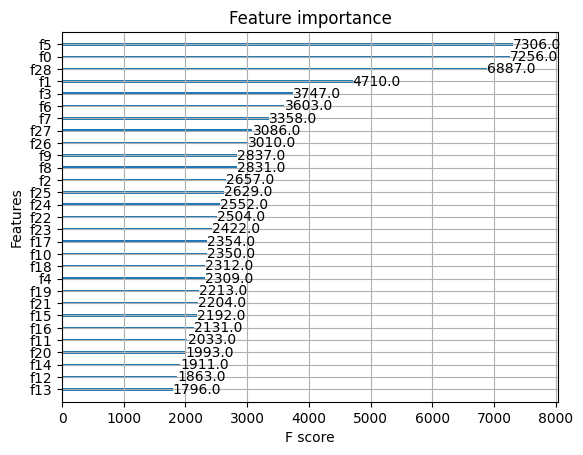

In [111]:
xgb.plot_importance(reg)

Test RMSE: 400.7130
Test MAPE: 2.60%


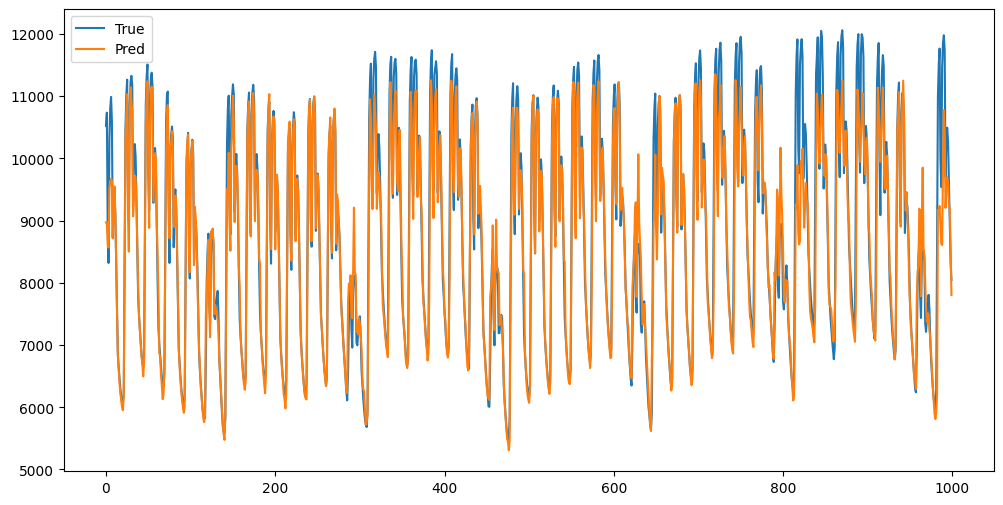

In [143]:
y_pred = test_pred
# calculate RMSE
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE: {rmse:.4f}')
# calculate MAPE
mape = 100 * (abs((y_test - y_pred) / y_test)).mean()
print(f'Test MAPE: {mape:.2f}%')
# 画出预测值和真实值的对比
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test[:1000], label='True')
plt.plot(y_pred[:1000], label='Pred')
plt.legend()
plt.show()

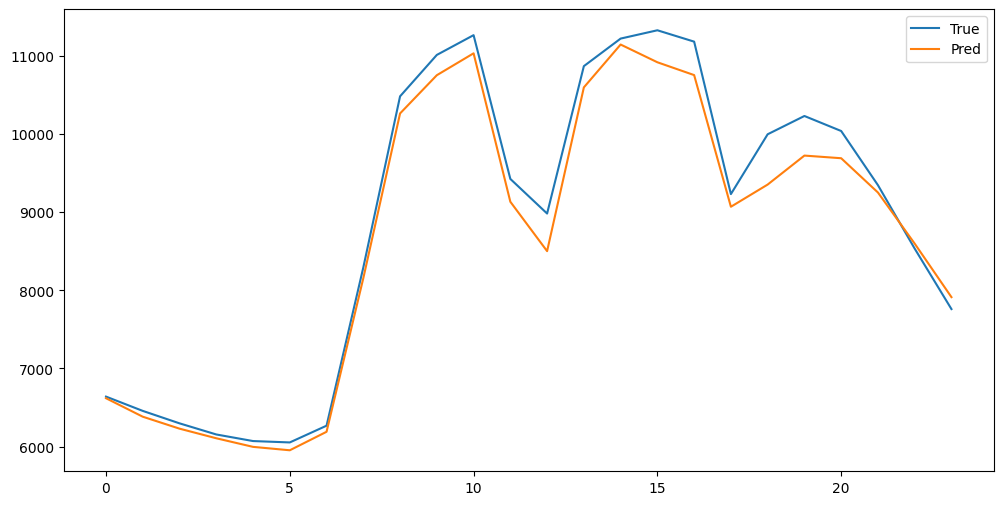

In [141]:
# 选出一天24小时的数据进行对比
plt.figure(figsize=(12, 6))
plt.plot(y_test[15:39], label='True')
plt.plot(y_pred[15:39], label='Pred')
plt.legend()
plt.show()